# Evaluate models’ performance in held out outer folds for version

x86_64-w64-mingw32, x86_64, mingw32, ucrt, x86_64, mingw32, , 4, 3.2, 2023, 10, 31, 85441, R, R version 4.3.2 (2023-10-31 ucrt), Eye Holes

Gaylen Fronk, John Curtin, & Kendra Wyant  
April 4, 2024

### Code Status

In use with iterative improvement

### Notes

This is a generic script that reproduces the CV metrics for the best model configuration, calculates various performance metrics from that resampling, makes plots, and then fits the best config to the final sample to do feature importance.

### Set Up Environment

In [ ]:
study <- "insight"
version <- "v2"
cv <- "nested"


Function conflicts

In [ ]:

# source
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.6     ✔ workflows    1.1.3
✔ modeldata    1.3.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.3.0
✔ recipes      1.0.9     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

Source support functions

In [ ]:
# EDA
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_eda.R?raw=true")


ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "bb7bddab14e337e74cb65ad3b94d58a2492d34cd"

Absolute paths

In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_input <- str_c("P:/studydata/risk/chtc/", study)
          path_processed <- str_c("P:/studydata/risk/data_processed/", study)
          path_models <- str_c("P:/studydata/risk/models/", study)
          path_knits <- str_c("P:/studydata/risk/knits/", study)},
        
        # IOS paths
        Darwin = {
          path_input <- str_c("/Volumes/private/studydata/risk/chtc/", study)
          path_processed <- str_c("/Volumes/private/studydata/risk/data_processed/",
                                  study)
          path_models <- str_c("/Volumes/private/studydata/risk/models/", study)
          path_knits <- str_c("/Volumes/private/studydata/risk/knits/", study)},
        
        # Linux paths
        Linux = {
          path_input <- str_c("~/mnt/private/studydata/risk/chtc/", study)
          path_processed <- str_c("~/mnt/private/studydata/risk/data_processed/",
                                  study)
          path_models <- str_c("~/mnt/private/studydata/risk/models/", study)
          path_knits <- str_c("~/mnt/private/studydata/risk/knits/", study)}
)


Chunk Defaults

In [ ]:

knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


Source training controls

In [ ]:
# EDA
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_eda.R?raw=true")


ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "bb7bddab14e337e74cb65ad3b94d58a2492d34cd"

ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

Knit to specific directory

In [ ]:
# Render knit file manually to different location

rmarkdown::render(input = file.path(
  "insight/mak_scripts/3_eval_outer.qmd"),
  output_dir = file.path(path_knits),
  output_file = str_c("3_eval_outer_", version, ".html"),
  env = new.env())


### Model Performance Metrics

In [ ]:
all_files <- list.files(path_models, full.names = TRUE) 
preds_files <- all_files[str_detect(all_files, "outer_preds_") &
                           str_detect(all_files, version)]

preds_out <- preds_files |> 
  map(\(file) read_rds(file) |> 
        mutate(model = str_extract(file, "(?<=outer_preds_)[:graph:]+(?=_v2_)")) |> 
        select(model, outer_split_num, prob_raw, label)) |> 
  list_rbind()

glimpse(preds_out)


Rows: 89,058
Columns: 4
$ model           <chr> "1week_aase_only", "1week_aase_only", "1week_aase_only…
$ outer_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_raw        <dbl> 0.4648062, 0.4648062, 0.4648062, 0.4648062, 0.4648062,…
$ label           <fct> No lapse, No lapse, No lapse, No lapse, No lapse, No l…

Rows: 120
Columns: 24
$ outer_split_num <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…
$ algorithm       <chr> "xgboost", "xgboost", "xgboost", "xgboost", "xgboost",…
$ feature_set     <chr> "aase_only", "aase_only", "aase_only", "aase_only", "a…
$ hp1             <dbl> 1e-03, 1e-04, 1e-02, 1e-04, 1e-02, 1e-02, 1e-03, 1e-01…
$ hp2             <dbl> 2, 3, 1, 3, 2, 1, 4, 4, 2, 2, 4, 1, 3, 1, 4, 3, 2, 1, …
$ hp3             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ resample        <chr> "up_2", "none", "up_2", "down_2", "up_2", "smote_1", "…
$ roc_auc         <dbl> 0.7859752, 0.4456172, 0.6300183, 0.4173161, 0.5234222,…
$ sens            <dbl> 0.00000000, 0.05660377, 0.00000000, 0.17050691, 0.0691…
$ spec            <dbl> 1.0000000, 0.9371981, 1.0000000, 0.7732843, 0.9118012,…
$ ppv             <dbl> NaN, 0.27777778, NaN, 0.16666667, 0.17441860, 0.488413…
$ npv             <dbl> 0.7521614, 0.6995192, 0.6858696, 0.7780518, 0.7841880,…
$ accuracy        

#### Inner Loop AUC

Best model configurations were selected using the median AUCs across 10 inner folds. 30 (3x10) models were selected.

In [ ]:
metrics_out |> 
  group_by(model) |> 
  summarize(median(roc_auc_in), mean(roc_auc_in), min(roc_auc_in), max(roc_auc_in), sd(roc_auc_in))


# A tibble: 4 × 6
  model                 `median(roc_auc_in)` `mean(roc_auc_in)`
  <chr>                                <dbl>              <dbl>
1 1week_aase_only                      0.647              0.655
2 1week_all                            0.884              0.882
3 1week_insight_only                   0.801              0.799
4 dichotomous_aase_only                0.704              0.707
  `min(roc_auc_in)` `max(roc_auc_in)` `sd(roc_auc_in)`
              <dbl>             <dbl>            <dbl>
1             0.600             0.732           0.0375
2             0.855             0.912           0.0126
3             0.748             0.844           0.0211
4             0.672             0.787           0.0267

#### Outer AUC

Best model configurations were evaluated using the AUCs from the 30 (3x10) outer folds

Outer overall

In [ ]:
metrics_out |> 
  group_by(model) |> 
  summarize(median(roc_auc), mean(roc_auc))


# A tibble: 4 × 3
  model                 `median(roc_auc)` `mean(roc_auc)`
  <chr>                             <dbl>           <dbl>
1 1week_aase_only                   0.588           0.582
2 1week_all                         0.879           0.864
3 1week_insight_only                0.796           0.785
4 dichotomous_aase_only             0.561           0.576

Side by side of inner & outer median AUCs

In [ ]:
metrics_out |> 
  group_by(model) |> 
  summarize(median(roc_auc), median(roc_auc_in))


# A tibble: 4 × 3
  model                 `median(roc_auc)` `median(roc_auc_in)`
  <chr>                             <dbl>                <dbl>
1 1week_aase_only                   0.588                0.647
2 1week_all                         0.879                0.884
3 1week_insight_only                0.796                0.801
4 dichotomous_aase_only             0.561                0.704

Plot outer folds

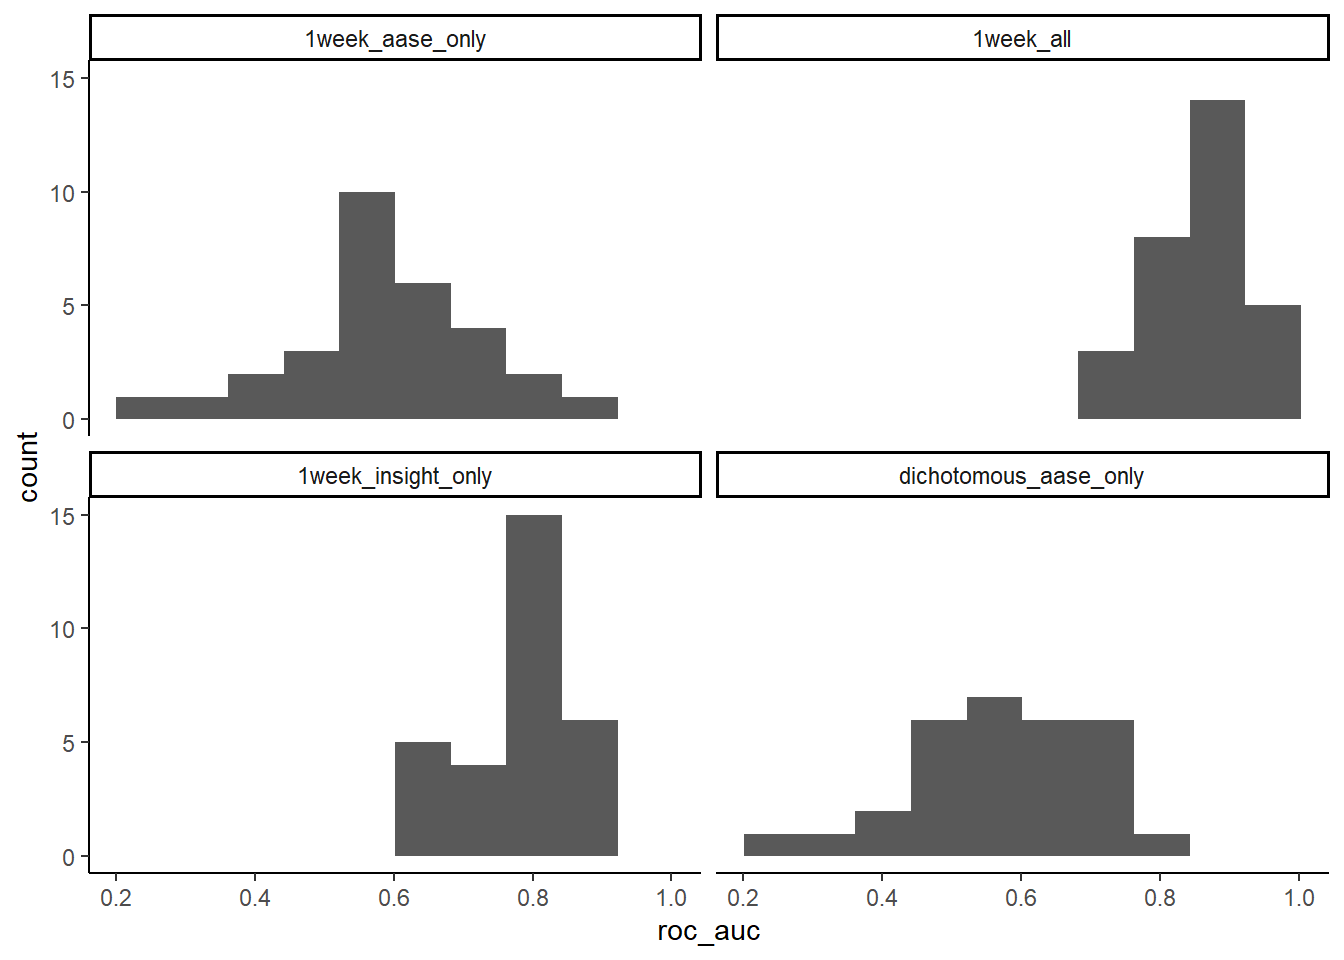

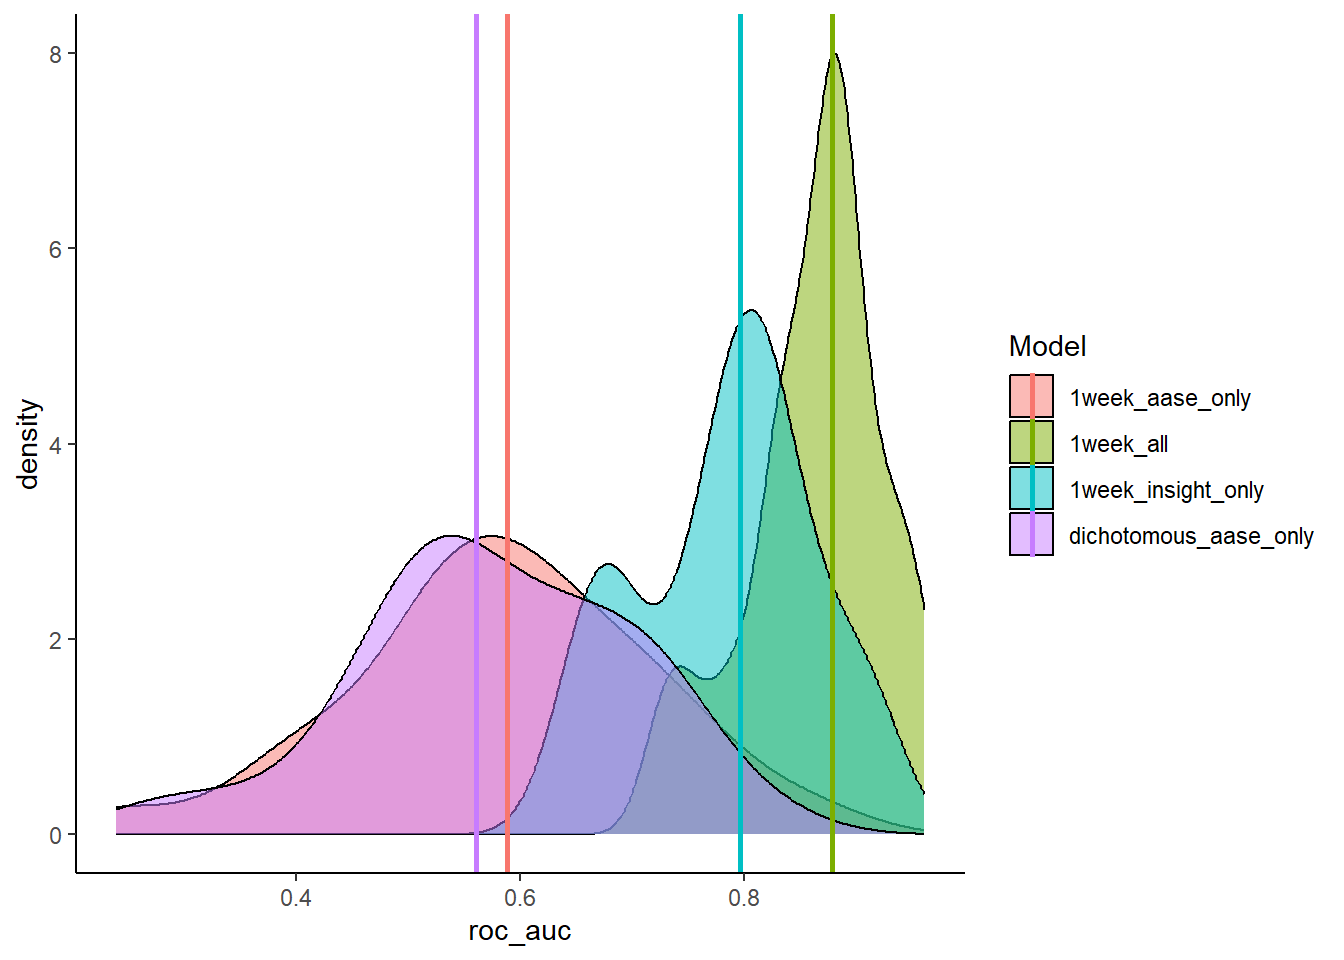

In [ ]:
# histograms faceted by model
metrics_out |> 
  ggplot(aes(x = roc_auc)) +
  geom_histogram(bins = 10) +
  facet_wrap(vars(model), ncol = 2)


Table for each outer fold

In [ ]:
models <- unique(metrics_out$model)

metrics_out |> 
  filter(model == "1week_all") |> 
  print_kbl()


#### Outer individual metrics

*1 week / all features model*

Default threshold (0.5)

          Truth
Prediction Lapse No lapse
  Lapse     4892     2535
  No lapse  2434    19674

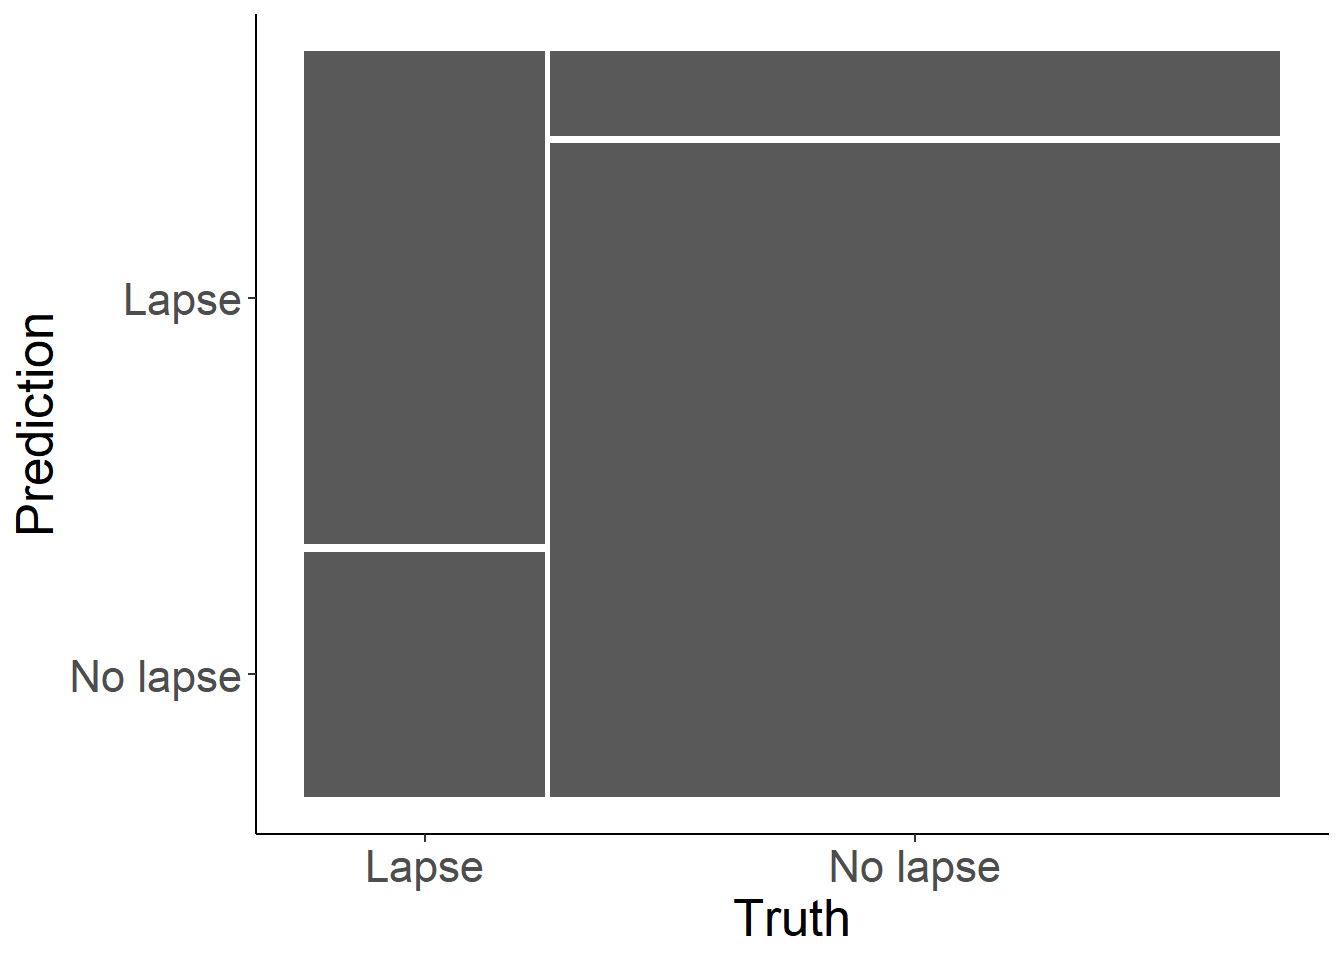

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.832
 2 kap                  binary         0.551
 3 sens                 binary         0.668
 4 spec                 binary         0.886
 5 ppv                  binary         0.659
 6 npv                  binary         0.890
 7 mcc                  binary         0.551
 8 j_index              binary         0.554
 9 bal_accuracy         binary         0.777
10 detection_prevalence binary         0.251
11 precision            binary         0.659
12 recall               binary         0.668
13 f_meas               binary         0.663

In [ ]:
(cm <- preds_out |> 
   filter(model == "1week_all") |> 
   mutate(estimate = if_else(prob_raw > .5, "Lapse", "No lapse"), # note changed from prob_beta while debugging
          estimate = factor(estimate, levels = c("Lapse", "No lapse"))) |> 
   conf_mat(truth = label, estimate = estimate))


Confusion matrix at optimal cut-point (based on Youdens J index)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1444894/ https://pubmed.ncbi.nlm.nih.gov/15405679/

# A tibble: 1 × 4
  .threshold specificity sensitivity     j
       <dbl>       <dbl>       <dbl> <dbl>
1      0.499       0.859       0.712 0.570

          Truth
Prediction Lapse No lapse
  Lapse     5212     3138
  No lapse  2114    19071

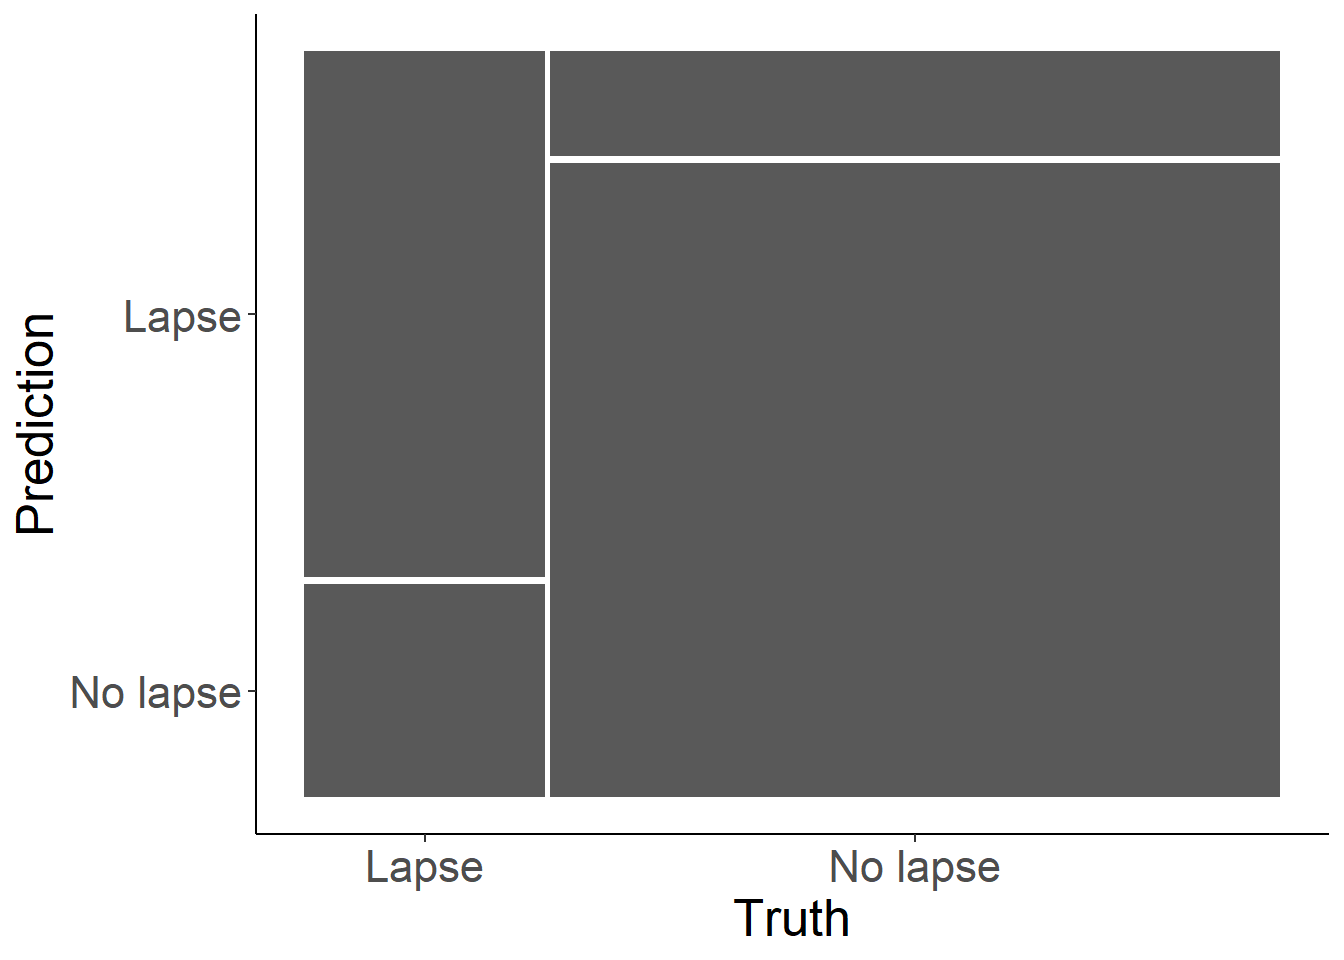

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.822
 2 kap                  binary         0.545
 3 sens                 binary         0.711
 4 spec                 binary         0.859
 5 ppv                  binary         0.624
 6 npv                  binary         0.900
 7 mcc                  binary         0.547
 8 j_index              binary         0.570
 9 bal_accuracy         binary         0.785
10 detection_prevalence binary         0.283
11 precision            binary         0.624
12 recall               binary         0.711
13 f_meas               binary         0.665

In [ ]:
roc_data <- preds_out %>%
  filter(model == "1week_all") |> 
  roc_curve(prob_raw, truth = label)

j_thres_roc <- roc_data |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
  print() |> 
  pull(.threshold)


*1 week / insight_only model*

Default threshold (0.5)

          Truth
Prediction Lapse No lapse
  Lapse     4953     5193
  No lapse  2373    17016

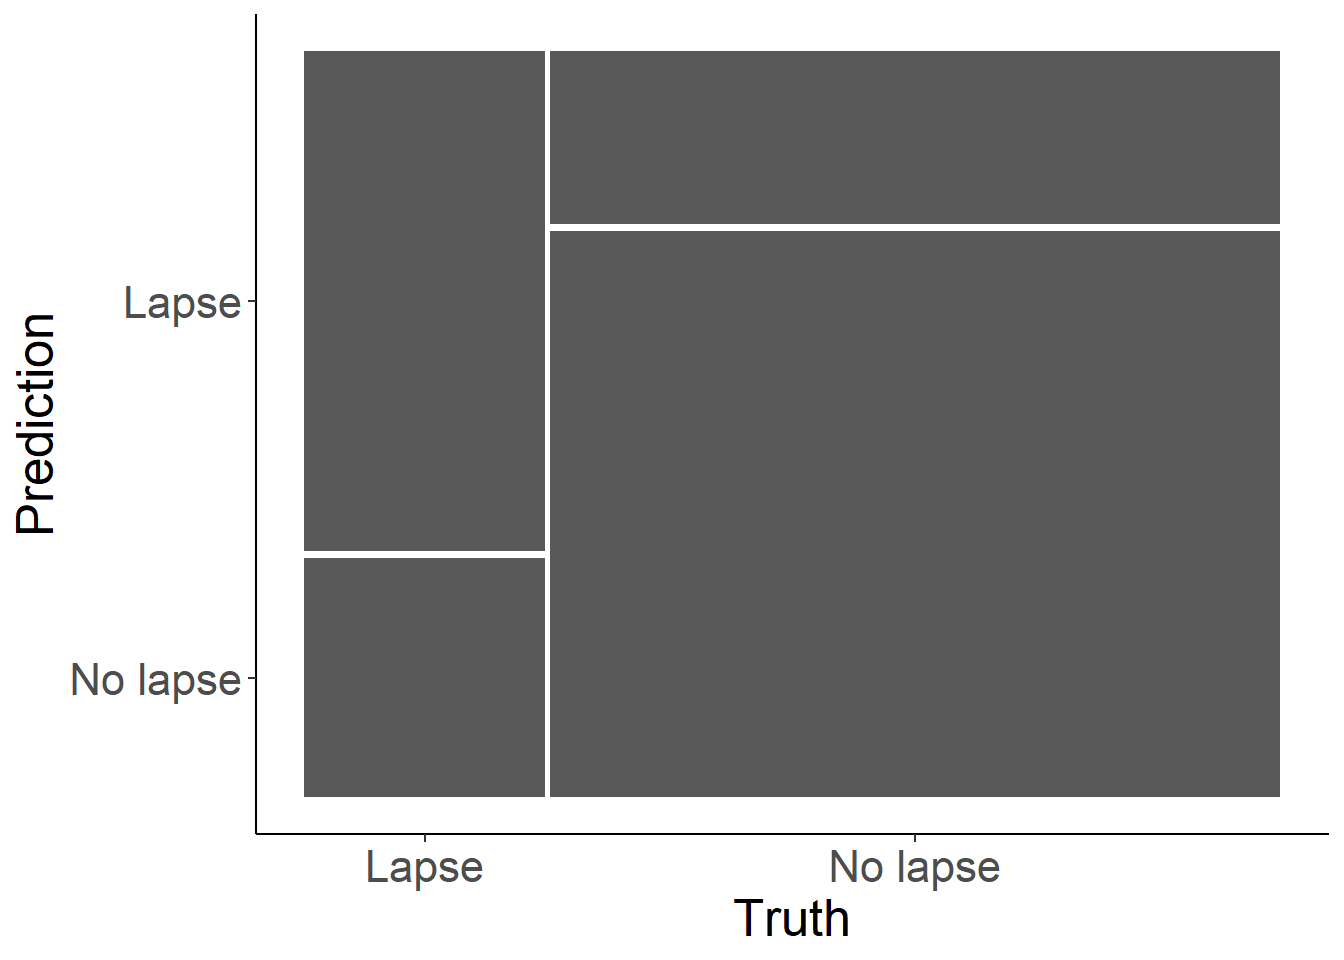

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.744
 2 kap                  binary         0.392
 3 sens                 binary         0.676
 4 spec                 binary         0.766
 5 ppv                  binary         0.488
 6 npv                  binary         0.878
 7 mcc                  binary         0.402
 8 j_index              binary         0.442
 9 bal_accuracy         binary         0.721
10 detection_prevalence binary         0.344
11 precision            binary         0.488
12 recall               binary         0.676
13 f_meas               binary         0.567

In [ ]:
(cm <- preds_out |> 
   filter(model == "1week_insight_only") |> 
   mutate(estimate = if_else(prob_raw > .5, "Lapse", "No lapse"), # note changed from prob_beta while debugging
          estimate = factor(estimate, levels = c("Lapse", "No lapse"))) |> 
   conf_mat(truth = label, estimate = estimate))


Confusion matrix at optimal cut-point (based on Youdens J index)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1444894/ https://pubmed.ncbi.nlm.nih.gov/15405679/

# A tibble: 1 × 4
  .threshold specificity sensitivity     j
       <dbl>       <dbl>       <dbl> <dbl>
1      0.489       0.729       0.719 0.447

          Truth
Prediction Lapse No lapse
  Lapse     5238     5966
  No lapse  2088    16243

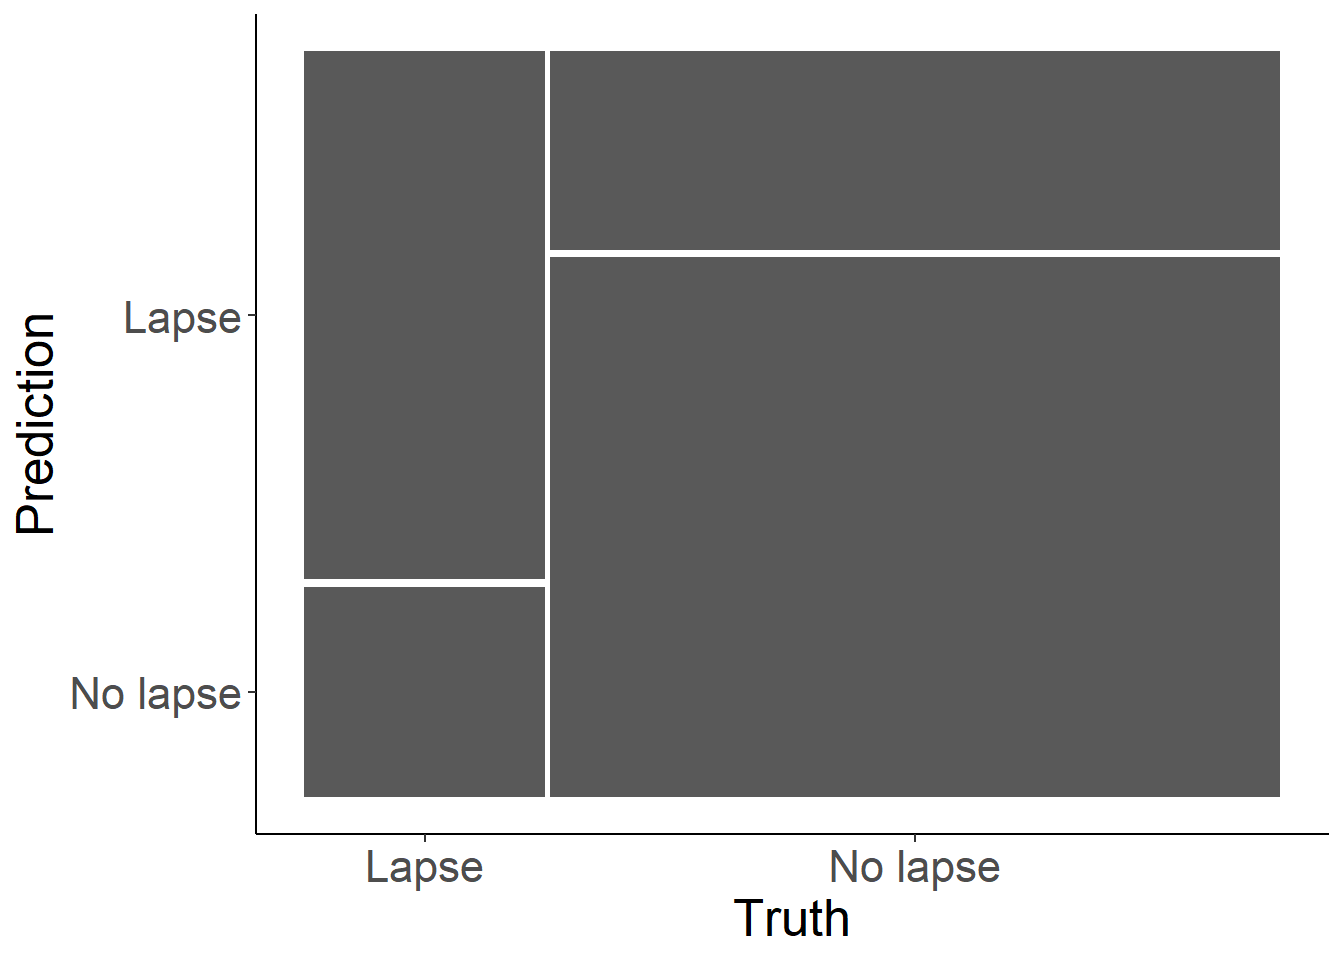

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.727
 2 kap                  binary         0.379
 3 sens                 binary         0.715
 4 spec                 binary         0.731
 5 ppv                  binary         0.468
 6 npv                  binary         0.886
 7 mcc                  binary         0.397
 8 j_index              binary         0.446
 9 bal_accuracy         binary         0.723
10 detection_prevalence binary         0.379
11 precision            binary         0.468
12 recall               binary         0.715
13 f_meas               binary         0.565

In [ ]:
roc_data <- preds_out %>%
  filter(model == "1week_insight_only") |> 
  roc_curve(prob_raw, truth = label)

j_thres_roc <- roc_data |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
  print() |> 
  pull(.threshold)


*1 week / aase_only model*

Default threshold (0.5)

          Truth
Prediction Lapse No lapse
  Lapse     2376     4568
  No lapse  4950    17641

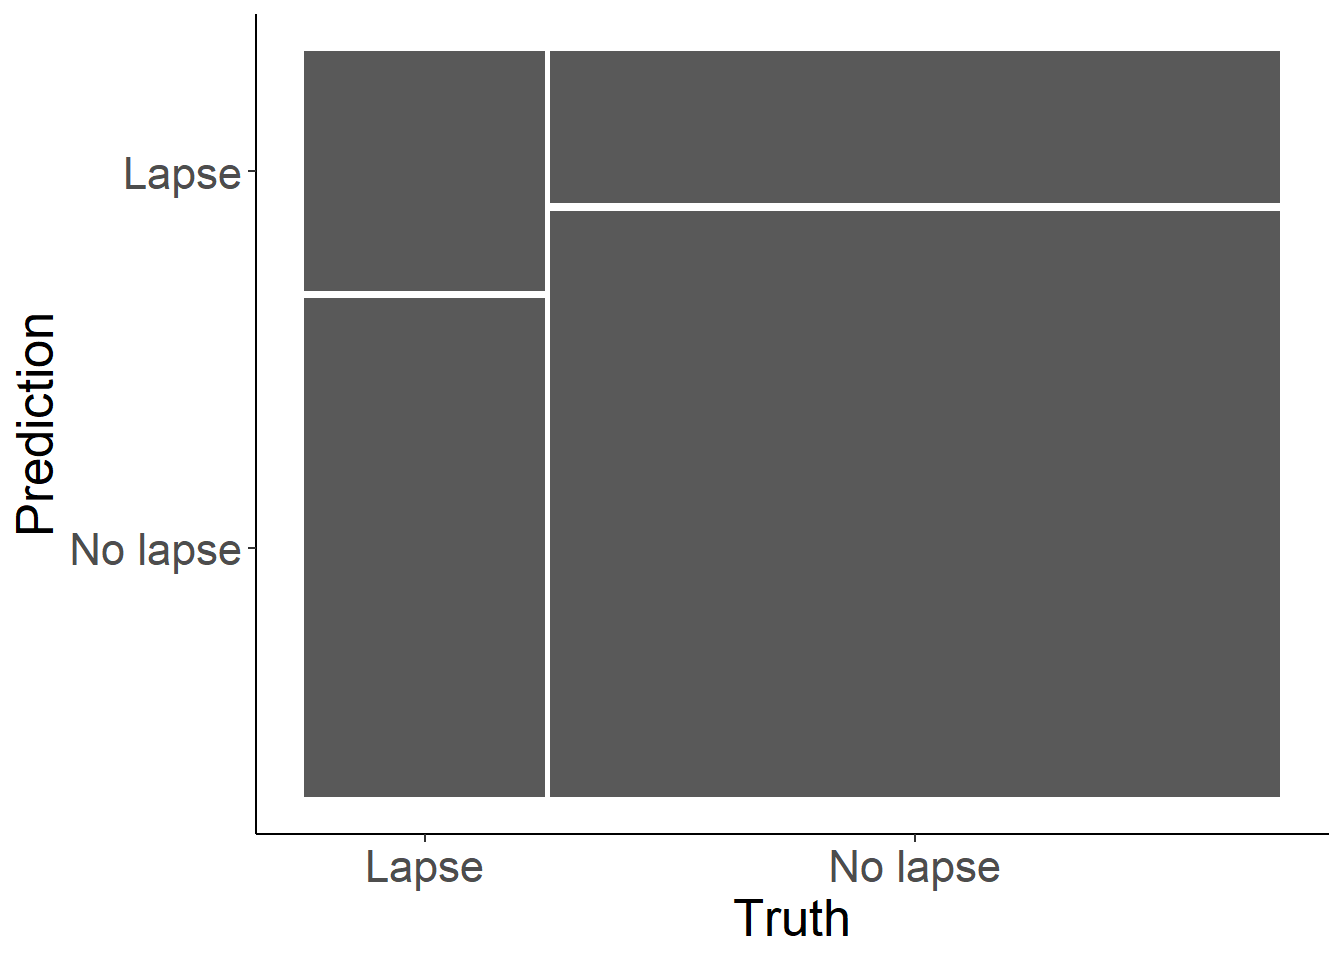

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.678
 2 kap                  binary         0.121
 3 sens                 binary         0.324
 4 spec                 binary         0.794
 5 ppv                  binary         0.342
 6 npv                  binary         0.781
 7 mcc                  binary         0.121
 8 j_index              binary         0.119
 9 bal_accuracy         binary         0.559
10 detection_prevalence binary         0.235
11 precision            binary         0.342
12 recall               binary         0.324
13 f_meas               binary         0.333

In [ ]:
(cm <- preds_out |> 
   filter(model == "1week_aase_only") |> 
   mutate(estimate = if_else(prob_raw > .5, "Lapse", "No lapse"), # note changed from prob_beta while debugging
          estimate = factor(estimate, levels = c("Lapse", "No lapse"))) |> 
   conf_mat(truth = label, estimate = estimate))


Confusion matrix at optimal cut-point (based on Youdens J index)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1444894/ https://pubmed.ncbi.nlm.nih.gov/15405679/

# A tibble: 1 × 4
  .threshold specificity sensitivity     j
       <dbl>       <dbl>       <dbl> <dbl>
1      0.505       0.813       0.314 0.127

          Truth
Prediction Lapse No lapse
  Lapse     2285     4113
  No lapse  5041    18096

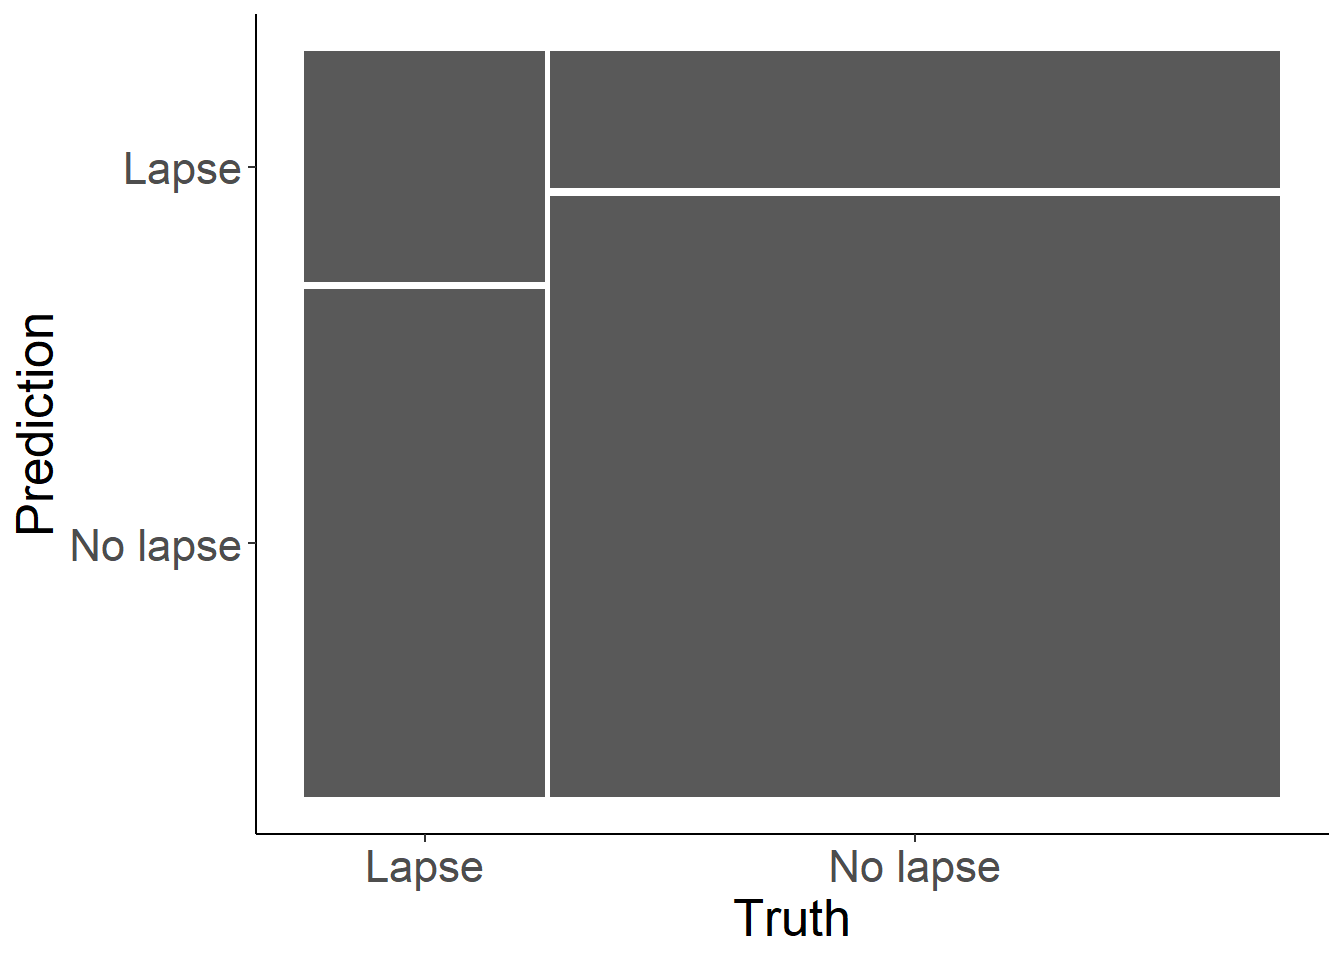

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.690
 2 kap                  binary         0.132
 3 sens                 binary         0.312
 4 spec                 binary         0.815
 5 ppv                  binary         0.357
 6 npv                  binary         0.782
 7 mcc                  binary         0.133
 8 j_index              binary         0.127
 9 bal_accuracy         binary         0.563
10 detection_prevalence binary         0.217
11 precision            binary         0.357
12 recall               binary         0.312
13 f_meas               binary         0.333

In [ ]:
roc_data <- preds_out %>%
  filter(model == "1week_aase_only") |> 
  roc_curve(prob_raw, truth = label)

j_thres_roc <- roc_data |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
  print() |> 
  pull(.threshold)


*Dichotomous / aase_only model*

Default threshold (0.5)

          Truth
Prediction Lapse No lapse
  Lapse      175      118
  No lapse    77       83

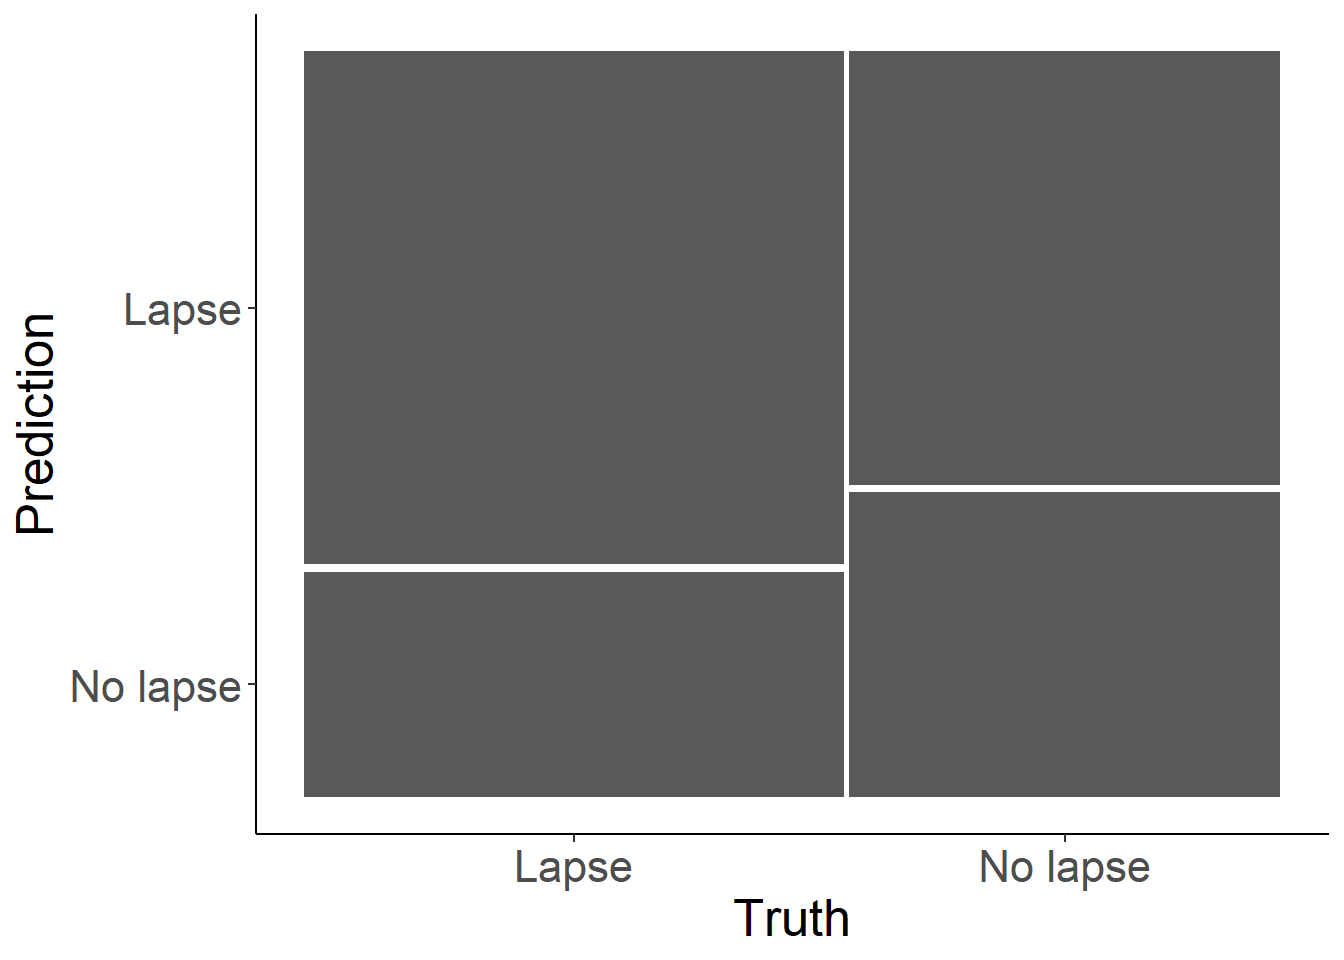

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.570
 2 kap                  binary         0.110
 3 sens                 binary         0.694
 4 spec                 binary         0.413
 5 ppv                  binary         0.597
 6 npv                  binary         0.519
 7 mcc                  binary         0.112
 8 j_index              binary         0.107
 9 bal_accuracy         binary         0.554
10 detection_prevalence binary         0.647
11 precision            binary         0.597
12 recall               binary         0.694
13 f_meas               binary         0.642

In [ ]:
(cm <- preds_out |> 
   filter(model == "dichotomous_aase_only") |> 
   mutate(estimate = if_else(prob_raw > .5, "Lapse", "No lapse"), # note changed from prob_beta while debugging
          estimate = factor(estimate, levels = c("Lapse", "No lapse"))) |> 
   conf_mat(truth = label, estimate = estimate))


Confusion matrix at optimal cut-point (based on Youdens J index)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1444894/ https://pubmed.ncbi.nlm.nih.gov/15405679/

# A tibble: 1 × 4
  .threshold specificity sensitivity     j
       <dbl>       <dbl>       <dbl> <dbl>
1      0.501       0.562       0.579 0.142

          Truth
Prediction Lapse No lapse
  Lapse      141       86
  No lapse   111      115

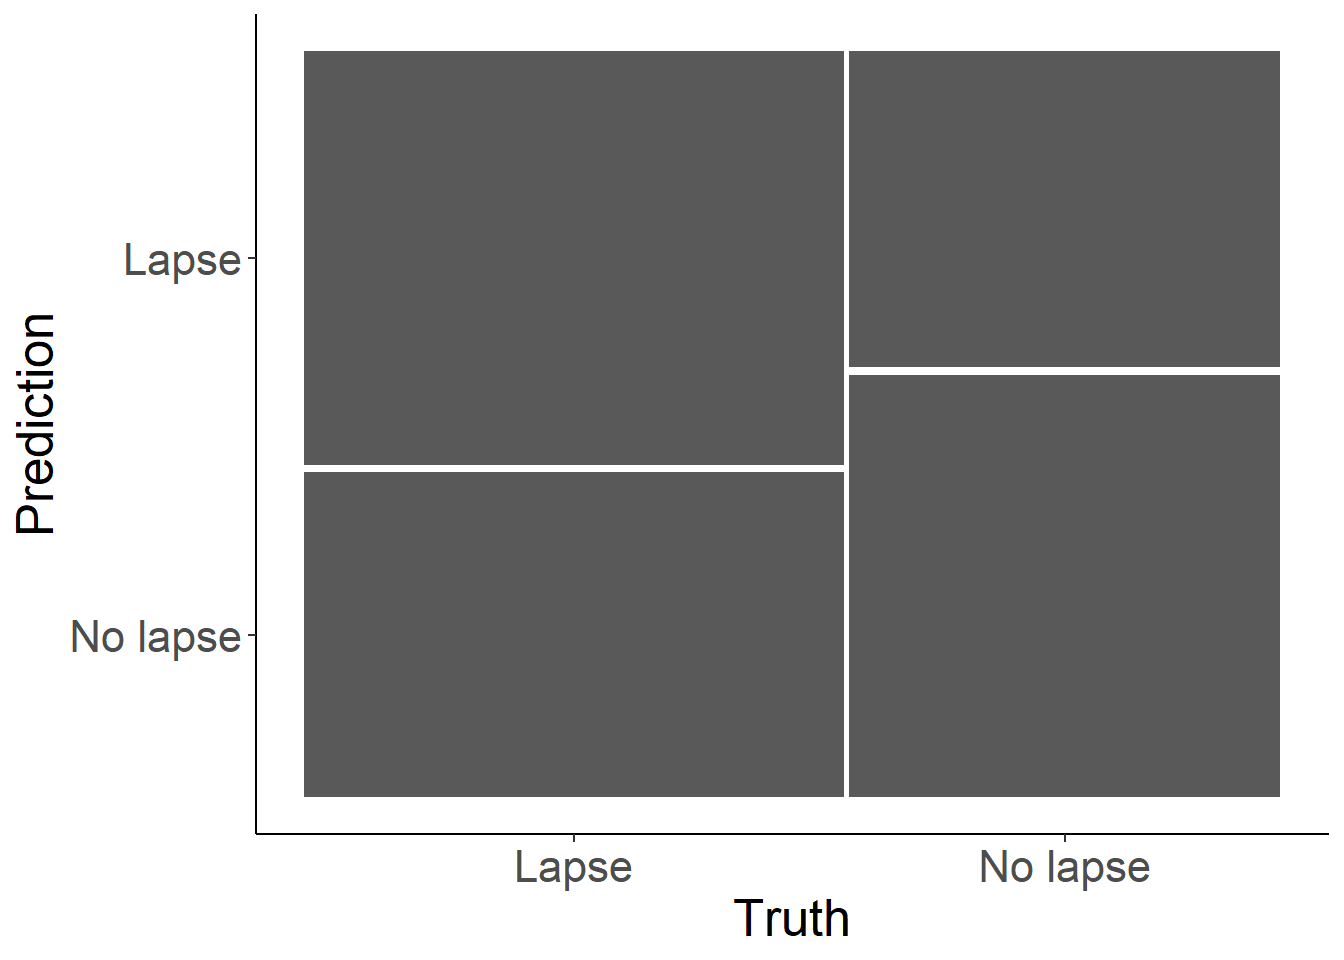

# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.565
 2 kap                  binary         0.130
 3 sens                 binary         0.560
 4 spec                 binary         0.572
 5 ppv                  binary         0.621
 6 npv                  binary         0.509
 7 mcc                  binary         0.131
 8 j_index              binary         0.132
 9 bal_accuracy         binary         0.566
10 detection_prevalence binary         0.501
11 precision            binary         0.621
12 recall               binary         0.560
13 f_meas               binary         0.589

In [ ]:
roc_data <- preds_out %>%
  filter(model == "dichotomous_aase_only") |> 
  roc_curve(prob_raw, truth = label)

j_thres_roc <- roc_data |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
  print() |> 
  pull(.threshold)


### Feature Importance

#### Grouped Features

In [ ]:
shaps_files <- all_files[str_detect(all_files, "outer_shapsgrp") &
                           str_detect(all_files, version)]

shapsgrp_out <- shaps_files |> 
  map(\(file) read_rds(file) |> 
        mutate(model = str_extract(file, 
                                   "(?<=outer_shapsgrp_)[:graph:]+(?=_v2_)"))) |> 
  list_rbind()

glimpse(shapsgrp_out)


Rows: 128,136
Columns: 4
Groups: id_obs [9,845]
$ id_obs       <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…
$ variable_grp <fct> aase_total, aase_total, aase_total, aase_total, aase_tota…
$ value        <dbl> -0.2400294, -0.2400294, -0.2400294, -0.2400294, -0.240029…
$ model        <chr> "1week_aase_only", "1week_aase_only", "1week_aase_only", …

Global importance Shapley value plot for grouped features

*1 week / all features model*

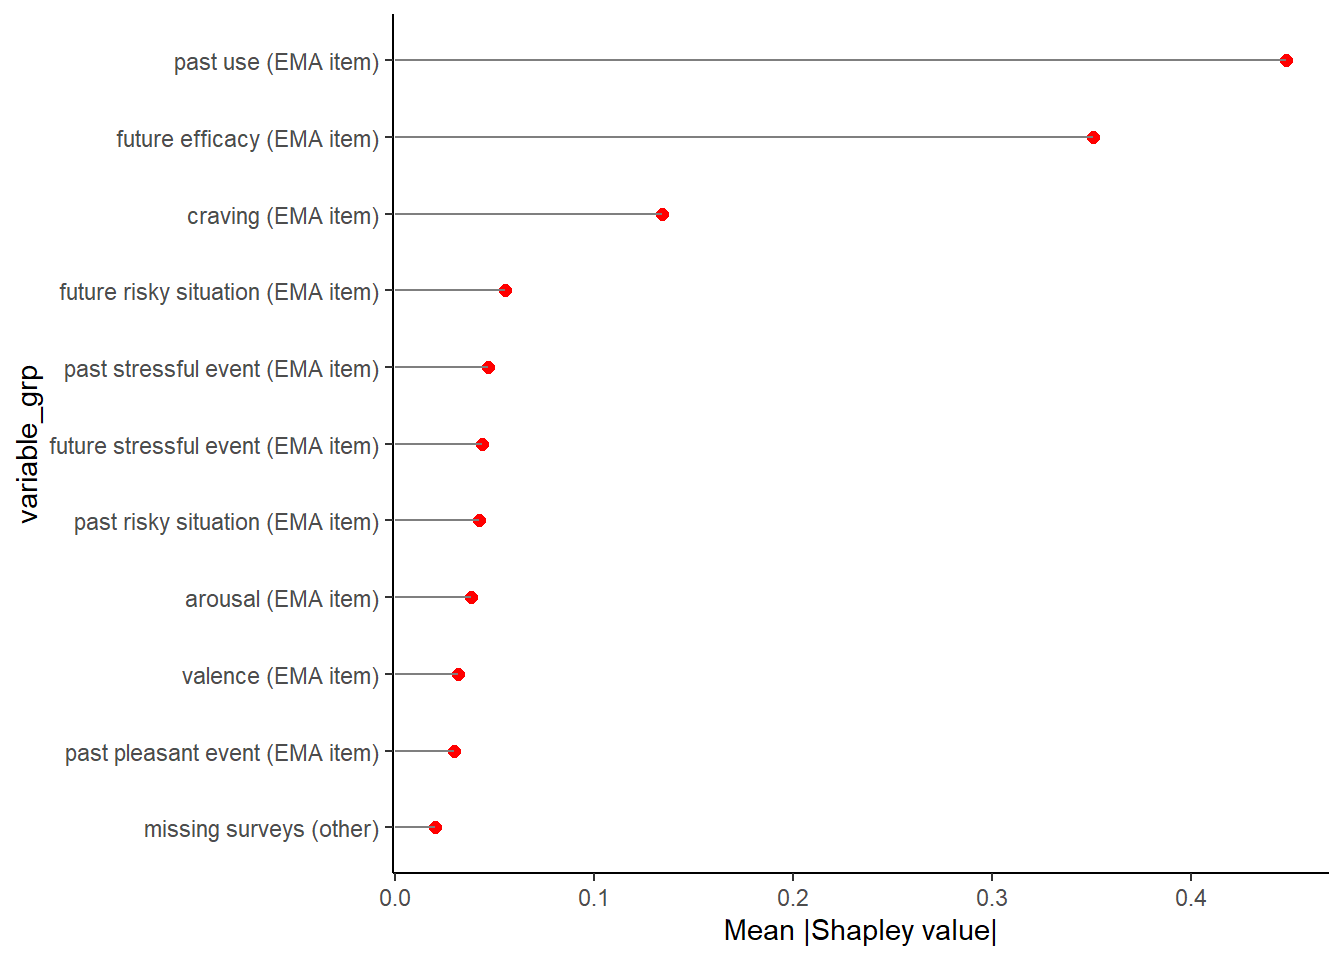

In [ ]:
shapsgrp_out %>% 
  filter(model == "1week_all") |> 
  group_by(variable_grp) %>% 
  summarize(mean_value = mean(abs(value)), .groups = "drop") %>% 
  arrange(mean_value) %>% 
  mutate(variable_grp = factor(variable_grp),
         variable_grp = fct_inorder(variable_grp)) %>% 
  ggplot(mapping = aes(x = variable_grp, y = mean_value)) +
  geom_point(size = 2, color = "red") +
  geom_segment(aes(x = variable_grp, y = mean_value, xend = variable_grp), 
               yend = 0, colour = "grey50")  +
  ylab("Mean |Shapley value|") +
  coord_flip()


Sina plot for grouped features

*1 week / all features model*

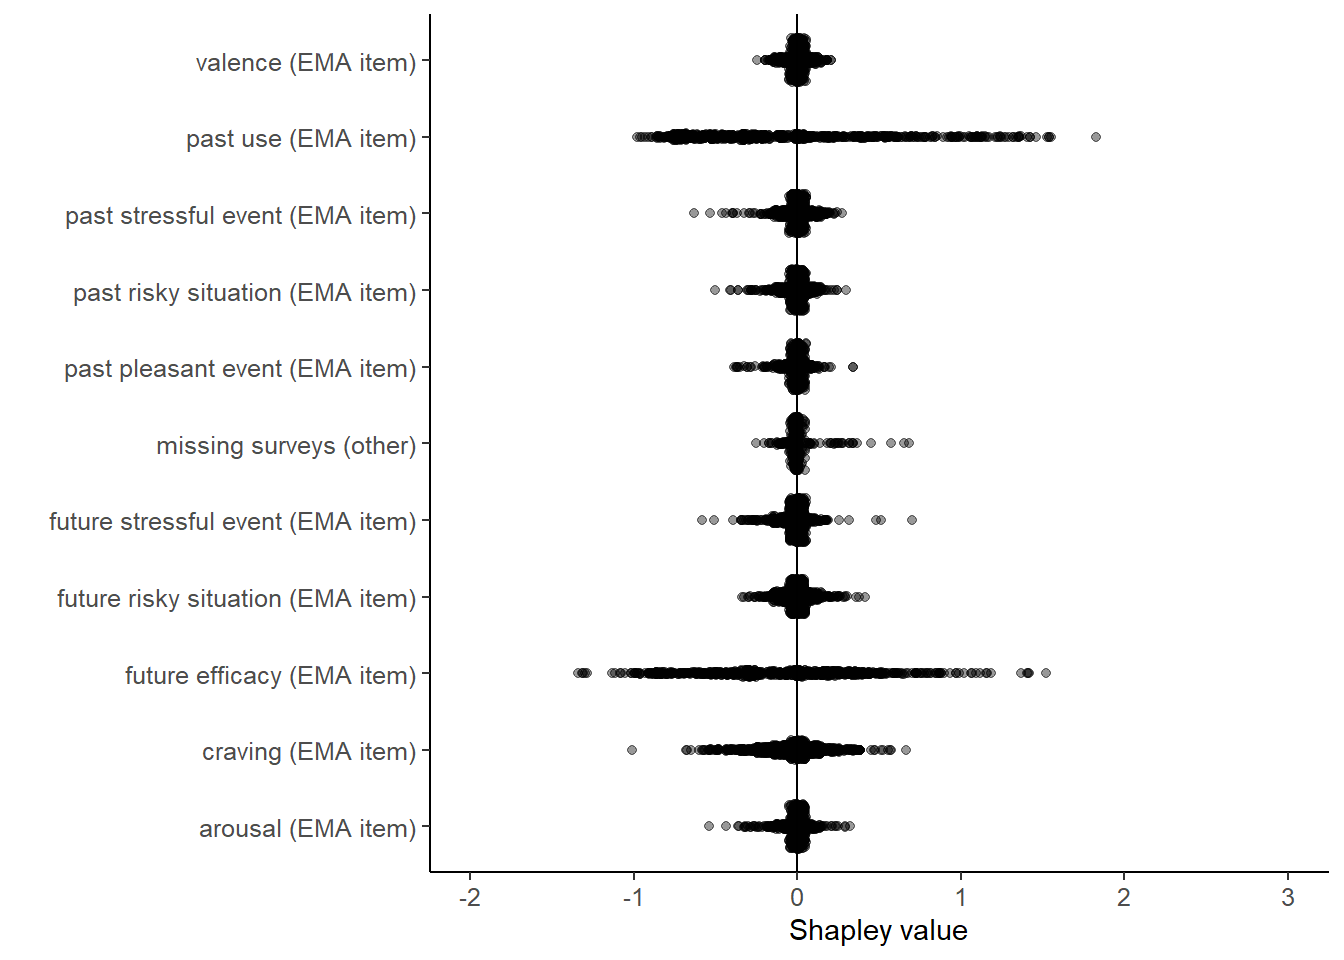

In [ ]:
# downsample to 10% of observations for plot
ids <- shapsgrp_out |> 
  filter(model == "1week_all") |> 
  pull(id_obs) |> 
  unique()
ids <- ids |> 
  sample(size = round(length(ids)/(1/.1)))

shapsgrp_out |> 
  filter(model == "1week_all" & id_obs %in% ids) |> 
  group_by(variable_grp) |> 
  mutate(variable_grp = factor(variable_grp)) |> 
  ggplot(mapping = aes(x = variable_grp, y = value)) +
  ggforce::geom_sina(method = "counts", maxwidth = 0.7, alpha = 0.4) +
  geom_hline(yintercept = 0) +
  scale_y_continuous(limits = c(-2, 3), breaks = seq(-2, 3)) +
  ylab("Shapley value") +
  xlab("") +
  theme(axis.text = element_text(size = 9.5)) +
  coord_flip()
